In [7]:
import pandas as pd
import swifter
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import dgl
import torch as th
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

In [8]:
chunks = []
for i in range(4):
    chunks.append(
        pd.read_pickle(f'pickles/gnn_score_table_chunk_{i}.pkl')
    )
    
article_index = pd.read_pickle("pickles/gnn_article_index.pkl")
customer_index = pd.read_pickle("pickles/gnn_customer_index.pkl")

recommendations = pd.concat(chunks, axis = 0)
recommendations.sort_values('customer_nid')


customer_nid                                         prediction  \
0                 0  [494, 215, 125, 1766, 96, 157, 254, 2031, 175,...   
1                 1  [494, 215, 125, 1766, 96, 157, 254, 2031, 175,...   
0                 2  [215, 494, 125, 1766, 96, 157, 254, 2031, 175,...   
2                 3  [215, 494, 125, 1766, 96, 157, 254, 2031, 175,...   
1                 4  [215, 494, 125, 1766, 96, 157, 254, 2031, 221,...   
...             ...                                                ...   
47295         59370  [494, 215, 125, 1766, 96, 157, 254, 2031, 175,...   
47296         59371  [215, 494, 125, 1766, 96, 157, 254, 2031, 175,...   
47297         59372  [494, 215, 125, 1766, 96, 157, 254, 2031, 175,...   
47298         59373  [215, 494, 125, 1766, 96, 157, 254, 2031, 175,...   
47299         59374  [215, 494, 125, 1766, 96, 157, 254, 2031, 175,...   

                                               articles  length  \
0                                                   [0]       1   
1                                  [1, 1, 28, 28, 3452]       5   
0                                             [2, 3, 4]       3   
2                                                   [5]       1   
1                                                   [6]       1   
...                                                 ...     ...   
47295                                       [226, 1366]       2   
47296  [488, 653, 1151, 2395, 2529, 7115, 10711, 11691]       8   
47297                                        [342, 910]       2   
47298                                             [513]       1   
47299                                            [1143]       1   

       prediction_length  
0                     12  
1                     12  
0                     12  
2                     12  
1                     12  
...                  ...  
47295                 12  
47296                 12  
47297                 12  
47298                 12  
47299                 12  

[59375 rows x 5 columns]

In [9]:
for i in range(12):
    recommendations[f"{i}"] = recommendations['prediction'].swifter.apply(lambda x: x[i])

/home/treb/anaconda3/lib/python3.9/site-packages/swifter/swifter.py:33: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(
Pandas Apply: 100%|██████████| 59375/59375 [00:00<00:00, 1659327.17it/s]


In [10]:
# Add real customers ID.
recommendations = recommendations.merge(customer_index[['customer_id', 'customer_nid']], left_on = "customer_nid", right_on = "customer_nid", how = "left")

# Add real articles IDs
for i in range(12):
    recommendations = recommendations.merge(article_index[['article_id', 'article_nid']], left_on = f"{i}", right_on = "article_nid", how = "left")
    recommendations.rename({f"article_id": f"article_{i}"}, axis = 1, inplace = True)
    
# Remove unused columns
recommendations.drop(columns = ['article_nid_x', 'article_nid_y', 'articles', 'customer_nid', 'prediction', 'length', 'prediction_length'], axis = 1, inplace = True)
recommendations.drop(columns = [f"{i}" for i in range(12)], axis = 1, inplace = True)

In [11]:
recommendations.drop(columns = ['11'], axis = 1, inplace = True)
recommendations.head()

KeyError: "['11'] not found in axis"

In [12]:
# Ajout de la liste des achats
transactions = pd.read_pickle("pickles/transactions_clean.pkl")
transactions = transactions[transactions["week_number"] == 0]
purchase_list = transactions.groupby('customer_id').agg(
    purchase_list = ('article_id', lambda x: list(x))
)
recommendations = recommendations.merge(purchase_list, on = 'customer_id', how = 'left')
recommendations.head()

customer_id   article_0   article_1  \
0  fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...  0923758001  0924243001   
1  53d5f95331b01525404c3cbb2da6a84e1173dccb979d28...  0923758001  0924243001   
2  53e3114ae37a37e34bff55eee908864ac2ca7b4204c2dc...  0924243001  0923758001   
3  53f61faa4c4f2c3e838c226ab57c61142087f69a6b1464...  0923758001  0924243001   
4  53fc32974ae9fb53dc7715aa5f5c21dad233d783d4208c...  0924243001  0923758001   

    article_2   article_3   article_4   article_5   article_6   article_7  \
0  0762846027  0809238005  0924243002  0918522001  0914805002  0903926001   
1  0762846027  0809238005  0924243002  0918522001  0914805002  0903926001   
2  0762846027  0809238005  0924243002  0918522001  0914805002  0903926001   
3  0762846027  0809238005  0924243002  0918522001  0914805002  0903926001   
4  0762846027  0809238005  0924243002  0918522001  0914805002  0903926001   

    article_8   article_9  article_10  article_11  \
0  0891763003  0929165002  0873279003  0865799006   
1  0891763003  0929165002  0873279003  0865799006   
2  0891763003  0929165002  0873279003  0865799006   
3  0891763003  0929165002  0873279003  0865799006   
4  0891763003  0929165002  0873279003  0865799006   

                                       purchase_list  
0                                       [0898573003]  
1  [0752814021, 0752814020, 0752814021, 091044900...  
2                                       [0866837004]  
3                                       [0899122001]  
4   [0680846001, 0841565005, 0903773001, 0915611004]

In [13]:
# Vérification

precision = recommendations.apply(
    lambda x: np.sum(
                np.where(
                    x[f"article_{i}"] in x['purchase_list'],
                    1,
                    0
                ) for i in range(12)
            ) / min(12, len(x['purchase_list'])),
    axis=1)

precision.mean()

/tmp/ipykernel_10913/1997005101.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  lambda x: np.sum(


0.02157863081947294

In [14]:
lines = []

def fill_predictions_table(row):
    
    if not row['purchase_list']:
        return
    
    # Test des Faux / Vrais positifs de la liste de prédiction
    prediction = []
    for i in range(12):
        article_id = row[f"article_{i}"]
        
        if article_id in row['purchase_list']:
            lines.append([row['customer_id'], article_id, 4, i]) # Vrais positifs
        elif i < len(row['purchase_list']):
            lines.append([row['customer_id'], article_id, 2, i]) # Faux positifs
            
        prediction.append(article_id)
        
    # Faux négatifs
    for article_id in row['purchase_list']:
        if article_id not in prediction:
            lines.append([row['customer_id'], article_id, 1, 0])
        

recommendations.iloc[:-1].swifter.apply(lambda x: fill_predictions_table(x), axis = 1)

predictions = pd.DataFrame(lines, columns = ['customer_id', 'article_id', 'class', 'position_in_prediction'])

predictions.head()

Pandas Apply: 100%|██████████| 59374/59374 [00:04<00:00, 12707.73it/s]


customer_id  article_id  class  \
0  52b212576d73f072f512301188c5963ed629fbd7410506...  0923758001      2   
1  52b212576d73f072f512301188c5963ed629fbd7410506...  0924243001      2   
2  52b212576d73f072f512301188c5963ed629fbd7410506...  0924243002      4   
3  52b212576d73f072f512301188c5963ed629fbd7410506...  0928351001      1   
4  4fa5dd887e97e50ecdc626dd2728241e077aa148a03030...  0923758001      2   

   position_in_prediction  
0                       0  
1                       1  
2                       4  
3                       0  
4                       0

In [15]:
predictions['class'].value_counts()

1    195066
2    191611
4      4016
Name: class, dtype: int64

In [16]:
# Ajout des features

customers = pd.read_pickle('pickles/customers_gnn_full.pkl')
articles = pd.read_pickle('pickles/articles_gnn_full.pkl')

data_to_analyze = predictions.merge(customers, on = 'customer_id', how = 'left')
data_to_analyze = data_to_analyze.merge(articles, on = 'article_id', how = 'left')
data_to_analyze.head()

customer_id  article_id  class  \
0  52b212576d73f072f512301188c5963ed629fbd7410506...  0923758001      2   
1  52b212576d73f072f512301188c5963ed629fbd7410506...  0924243001      2   
2  52b212576d73f072f512301188c5963ed629fbd7410506...  0924243002      4   
3  52b212576d73f072f512301188c5963ed629fbd7410506...  0928351001      1   
4  4fa5dd887e97e50ecdc626dd2728241e077aa148a03030...  0923758001      2   

   position_in_prediction  FN  Active  average_cart_interval  \
0                       0   0       0               3.380952   
1                       1   0       0               3.380952   
2                       4   0       0               3.380952   
3                       0   0       0               3.380952   
4                       0   0       0               8.514286   

   repurchases_interval  age_around_15  age_around_25  ...  \
0                 0.625            0.3            0.7  ...   
1                 0.625            0.3            0.7  ...   
2                 0.625            0.3            0.7  ...   
3                 0.625            0.3            0.7  ...   
4                 0.000            0.0            0.6  ...   

   department_name:Young Girl Jersey Basic  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   department_name:Young Girl Jersey Fancy  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   department_name:Young Girl Knitwear  department_name:Young Girl Outdoor  \
0                                    0                                   0   
1                                    0                                   0   
2                                    0                                   0   
3                                    0                                   0   
4                                    0                                   0   

   department_name:Young Girl S&T  department_name:Young Girl Shoes  \
0                               0                                 0   
1                               0                                 0   
2                               0                                 0   
3                               0                                 0   
4                               0                                 0   

   department_name:Young Girl Swimwear  department_name:Young Girl Trouser  \
0                                    0                                   0   
1                                    0                                   0   
2                                    0                                   0   
3                                    0                                   0   
4                                    0                                   0   

   department_name:Young Girl UW/NW  department_name:Young boy Swimwear  
0                                 0                                   0  
1                                 0                                   0  
2                                 0                                   0  
3                                 0                                   0  
4                                 0                                   0  

[5 rows x 623 columns]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


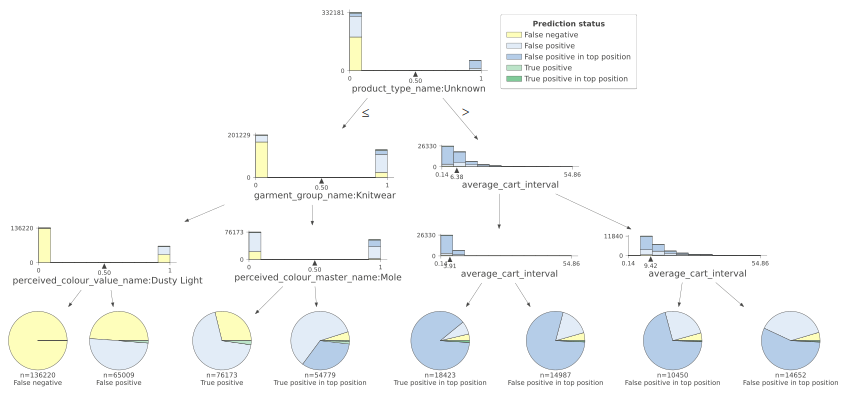

In [17]:

# On rajoute la notion de début / fin de classement
top_rank_threshold = 1
data_to_analyze['rank_class'] = data_to_analyze['class']
data_to_analyze.loc[
    (data_to_analyze['class'] == 2) & 
    (data_to_analyze['position_in_prediction'] < top_rank_threshold),
    'rank_class'
] = 3 # Faux positifs en top position
data_to_analyze.loc[
    (data_to_analyze['class'] == 4) & 
    (data_to_analyze['position_in_prediction'] < top_rank_threshold),
    'rank_class'
] = 5 # Vrais positifs en top position

features = data_to_analyze.drop(columns = ['customer_id', 'article_id', 'position_in_prediction', 'class', 'rank_class'], axis = 1)

from sklearn.tree import DecisionTreeClassifier, plot_tree

explainer = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10000, class_weight='balanced')
explainer.fit(features, data_to_analyze['rank_class'])


from dtreeviz.trees import dtreeviz # remember to load the package


class_colors = [None, # 0 classes
                None, # 1 class
                ["#FEFEBB","#a1dab4"], # 2 classes
                ["#ff0000","#00ff00",'#0000ff'], # colors were changed here
                ["#FEFEBB","#D9E6F5",'#a1dab4','#fee090'], # 4
                ["#FEFEBB", "#e2ecf7", '#b5cde8','#bce4c9','#80ca99'], # 5
                ["#FEFEBB",'#c7e9b4','#41b6c4','#2c7fb8','#fee090','#f46d43'], # 6
                ["#FEFEBB",'#c7e9b4','#7fcdbb','#41b6c4','#225ea8','#fdae61','#f46d43'], # 7
                ["#FEFEBB",'#edf8b1','#c7e9b4','#7fcdbb','#1d91c0','#225ea8','#fdae61','#f46d43'], # 8                                       ["#FEFEBB",'#c7e9b4','#41b6c4','#74add1','#4575b4','#313695','#fee090','#fdae61','#f46d43'], # 9
                ["#FEFEBB",'#c7e9b4','#41b6c4','#74add1','#4575b4','#313695','#fee090','#fdae61','#f46d43','#d73027'] # 10
]
viz = dtreeviz(explainer, features, data_to_analyze['rank_class'],
                target_name="Prediction status",
                feature_names=features.columns,
                colors = {'classes': class_colors},
                class_names=['False negative', 'False positive', 'False positive in top position', 'True positive', 'True positive in top position']
            )

viz